In [4]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os


In [5]:
datapath="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/data"
outputlabelbinarizer="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/model/videoclassificationbinarizer"
outputmodel="C:/Users/20112/Desktop/keras-video-classification/keras-video-classification/output/videoclassificationmodel"
# epoch=25
epoch=5
# initialize the set of labels from the spots activity dataset we are
# going to train our network on
LABELS = set(["iron_pillar", "qutub_minar","alai_darwaza"])


In [6]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images(datapath))
data = []
labels = []

[INFO] loading images...


In [7]:
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# if the label of the current image is not part of of the labels
	# are interested in, then ignore the image
	if label not in LABELS:
		continue

	# load the image, convert it to RGB channel ordering, and resize
	# it to be a fixed 224x224 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (299, 299))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)


In [8]:
data = np.array(data)
labels = np.array(labels)


In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)


In [10]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)



In [11]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [12]:
# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
baseModel = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')


In [13]:

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output

headModel =Flatten()(baseModel.output)
headModel = Dense(1024, activation='relu')(headModel)
headModel = Dropout(0.2)(headModel)
# headModel = Dense(len(lb.classes_), activation="softmax")

# # place the head FC model on top of the base model (this will become
# # the actual model we will train)
# model = Model(inputs=baseModel.input, outputs=headModel)
preds=Dense(3,activation='softmax')(headModel) #final layer with softmax activation

model=Model(inputs=baseModel.input,outputs=preds)

In [14]:
for layer in baseModel.layers:
	layer.trainable = False

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / epoch)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [15]:
print("[INFO] training head...")
H = model.fit(
	x=trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=epoch)


[INFO] training head...
Epoch 1/5
20/20 [==============================] - 96s 5s/step - loss: 241.3069 - accuracy: 0.3852 - val_loss: 0.8957 - val_accuracy: 0.5312
Epoch 2/5
20/20 [==============================] - 97s 5s/step - loss: 1.0385 - accuracy: 0.4639 - val_loss: 0.9102 - val_accuracy: 0.5052
Epoch 3/5
20/20 [==============================] - 103s 5s/step - loss: 0.9592 - accuracy: 0.5152 - val_loss: 0.7811 - val_accuracy: 0.6354
Epoch 4/5
20/20 [==============================] - 104s 5s/step - loss: 0.9175 - accuracy: 0.5538 - val_loss: 0.8243 - val_accuracy: 0.6042
Epoch 5/5
20/20 [==============================] - 94s 5s/step - loss: 0.8967 - accuracy: 0.5409 - val_loss: 0.9357 - val_accuracy: 0.4583


In [16]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(x=testX.astype("float32"), batch_size=32)



[INFO] evaluating network...


In [17]:
print(classification_report(
	testY.argmax(axis=1),predictions.argmax(axis=1), target_names=lb.classes_, digits = 6))
print(testY.argmax(axis=1))

              precision    recall  f1-score   support

alai_darwaza   0.625000  0.161290  0.256410        31
 iron_pillar   0.461165  0.989583  0.629139        96
 qutub_minar   1.000000  0.054348  0.103093        92

    accuracy                       0.479452       219
   macro avg   0.695388  0.401740  0.329547       219
weighted avg   0.710716  0.479452  0.355391       219

[0 1 1 0 1 1 2 1 2 1 0 0 1 1 0 2 2 2 1 1 2 2 1 0 1 2 2 2 1 1 2 2 1 2 2 2 1
 2 0 1 2 2 1 2 2 0 2 1 1 1 2 1 2 1 1 2 1 0 2 0 0 1 1 1 1 1 1 0 2 0 1 2 2 1
 2 1 2 2 2 1 1 1 0 1 1 0 2 2 0 0 2 1 2 2 0 0 0 2 2 1 1 0 1 2 1 1 1 0 2 0 2
 1 1 1 2 1 1 2 1 1 0 2 2 2 2 2 1 2 1 2 1 1 2 1 2 1 1 2 2 2 1 2 2 1 1 2 2 2
 1 1 2 1 0 1 1 0 2 1 2 1 2 2 1 2 2 2 1 0 1 2 0 1 1 2 2 0 1 2 2 1 2 2 1 2 1
 1 2 2 1 1 1 2 2 2 2 1 2 1 0 1 2 1 2 1 1 2 1 1 1 2 2 2 1 1 2 1 2 0 1]


In [18]:
from collections import Counter
Counter(testY.argmax(axis=1))
Counter(predictions.argmax(axis=1))

Counter({1: 206, 0: 8, 2: 5})

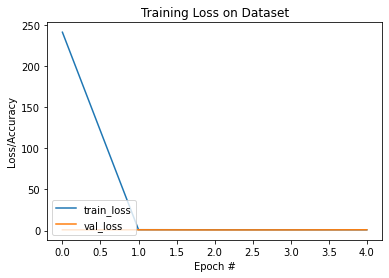

In [19]:
plt.figure()
plt.plot( H.history["loss"], label="train_loss")
plt.plot( H.history["val_loss"], label="val_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()  

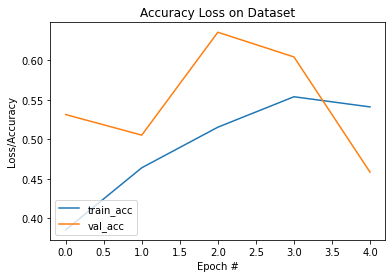

In [20]:
plt.figure()
plt.plot( H.history["accuracy"], label="train_acc")
plt.plot( H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()


In [21]:

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc



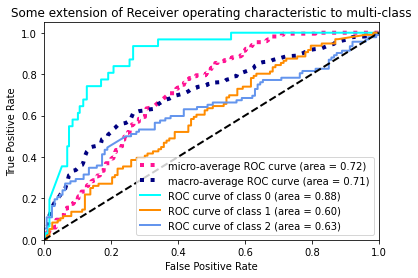

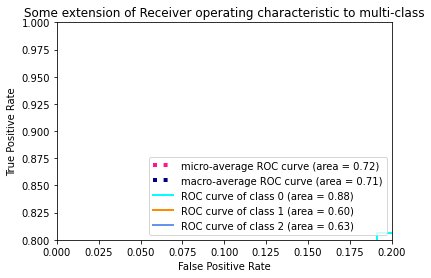

In [22]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
#y_score = model.predict(testX)
y_score=predictions
n_classes=3
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(testY[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testY.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()